# Imports

In [ ]:
import matplotlib

# Por defecto tiene matplotlib: 3.2.2
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.7.0


In [ ]:
# Se necesita la versión 3.5.1 que soporta float16 para pintar kanji
!pip install -U matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 82.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 KB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 KB 74.3 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [ ]:
# track time of each cell
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.6 MB/s eta 0:00:00
time: 369 µs (started: 2023-02-15 15:31:36 +00:00)


In [ ]:
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, subplots, show
import PIL as pil
import skimage.transform
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)
from tensorflow import keras
from keras.layers import (
    Conv2D, MaxPool2D, Flatten, Dense,
    Dropout, Input, Concatenate, GlobalAveragePooling2D
)
from keras.models import Model, Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

time: 3.33 s (started: 2023-02-15 15:31:39 +00:00)


In [ ]:
CHANNEL = 1
DATA_REPR = 'float32' # Antes era 'uint8'
NUM_CLASSES = 881
ETL_DATASET = 'etl_8G'
DNN_NAME = 'ResNet50'

USE_DATA_AUG = 'sin_DA' # o también con_DA
TYPE_IMG = 'regular' # o también inverted

TFM_PATH = '/content/gdrive/MyDrive/Master_IA/TFM/'
ROOT_PATH = TFM_PATH + 'datasets/'+ ETL_DATASET +'/uint32/imgs_{}/splits/'+ TYPE_IMG +'/'

# print('versión TF:', tf.__version__) # versión TF: 2.8.0
print('versión Keras:', keras.__version__) # versión Keras: 2.8.0

versión Keras: 2.11.0
time: 1 ms (started: 2023-02-15 15:31:42 +00:00)


In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive
time: 22.7 s (started: 2023-02-15 15:31:44 +00:00)


# Funciones

In [ ]:
def load_images_for_training(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - ROOT_PATH: Path in Google Drive where imgs and labels are stored
    - TYPE_IMG: regular o inverted

    Output:
    - np arrays for training and validation images
    '''

    if TYPE_IMG == 'regular':
        train_name_img = 'train_imgs_8G.npz'
        train_name_labels = 'train_labels_8G.npz'
        val_name_img = 'val_imgs_8G.npz'
        val_name_labels = 'val_labels_8G.npz'
    elif TYPE_IMG == 'inverted':
        train_name_img = 'train_inv_imgs_8G.npz'
        train_name_labels = 'train_inv_labels_8G.npz'
        val_name_img = 'val_inv_imgs_8G.npz'
        val_name_labels = 'val_inv_labels_8G.npz'

    train_images = np.load(PATH+train_name_img)['arr_0']
    train_labels = np.load(PATH+train_name_labels)['arr_0'].astype(DATA_REPR)

    val_images = np.load(PATH+val_name_img)['arr_0']
    val_labels = np.load(PATH+val_name_labels)['arr_0'].astype(DATA_REPR)

    return train_images, train_labels, val_images, val_labels


def load_test_images(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - ROOT_PATH: Path in Google Drive where imgs and labels are stored

    Output:
    - np arrays for testing images
    '''

    if TYPE_IMG == 'regular':
        test_name_img = 'test_imgs_8G.npz'
        test_name_labels = 'test_labels_8G.npz'
    elif TYPE_IMG == 'inverted':
        test_name_img = 'test_inv_imgs_8G.npz'
        test_name_labels = 'test_inv_labels_8G.npz'

    test_images = np.load(PATH+test_name_img)['arr_0']
    test_labels = np.load(PATH+test_name_labels)['arr_0'].astype(DATA_REPR)

    return test_images, test_labels


def create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL):

    image_input = Input(shape=(WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL))
    img_conc = Concatenate()([image_input, image_input, image_input])

    m_Resnet50_8G = keras.applications.ResNet50(
        include_top=False,
        input_tensor=img_conc,
        weights='imagenet',
    )

    last_layer = m_Resnet50_8G.layers[-1].output
    x = GlobalAveragePooling2D()(last_layer)
    out = Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)
    custom_model = Model(image_input, out)

    # freeze all the layers except the 2 newly added layers
    for layer in custom_model.layers[:-2]:
        layer.trainable = False

    return custom_model


def train_model(custom_model, train_images, train_labels, val_images, val_labels):

    callback = EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        patience=5,
        verbose=1
    )

    custom_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=Adam(learning_rate=0.0001),
        metrics=["sparse_categorical_accuracy"]
    )

    history = custom_model.fit(
        train_images,
        train_labels,
        validation_data=(val_images, val_labels),
        epochs= 50, # en 2022 usé 20 epochs
        callbacks = [callback],
    )

    print('--- Iterations ended ---')
    print()
    print()

    return history


def show_metrics(custom_model, test_images, test_labels):
    test_loss, test_accuracy = custom_model.evaluate(test_images, test_labels)
    y_pred = np.argmax(custom_model.predict(test_images), axis=1)

    print("*********************************************************************************************************************************")
    print()
    print("- Test Accuracy:", test_accuracy)
    print("- Test Loss:", test_loss)
    print("- time: ")
    print("- F1 score:", f1_score(test_labels, y_pred, average='weighted'))
    print("- Precision score:", precision_score(test_labels, y_pred, average='weighted'))
    print("- Recall: ", recall_score(test_labels, y_pred, average='weighted'))
    print("- Epoch: ")
    print("*********************************************************************************************************************************")


def plot_loss(history):
    pd.DataFrame(history.history).plot(figsize=(7,5))
    plt.grid(True)
    plt.gca().set_ylim(0,2) # usualmente 0,5
    plt.show()


def show_history(history):
    '''Recuperar una lista de resultados de la lista de datos de los conjuntos 
    de entrenamiento y pruebas para cada epoch de entrenamiento.
    '''

    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    #------------------------------------------------
    # Imprimir la precisión del entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Precisión de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.figure()

    #------------------------------------------------
    # Imprimir la perdida de entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Perdida de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.show()


def save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG):
    '''Guardar el modelo en disco duro
    
    Args:
        -SIZE: 64, 96, 112 ó 127
        -TFM_PATH = Ruta en drive a la carpeta del TFM
        -custom_model: Modelo de Deep Learning
        -TYPE_IMG: regular o inverted
    '''
    MODEL_NAME = f'model_resnet50_etl8_imgs{SIZE}_'+ TYPE_IMG +'.h5'
    WEIGHTS_PATH = TFM_PATH + 'notebooks/arqs_2023/ResNet50/weights_resnet50/' \
                + USE_DATA_AUG +'/'+ TYPE_IMG +'/' + MODEL_NAME

    custom_model.save(WEIGHTS_PATH) # lo guarda es en el notebook

    print('------ Model Saved -------')


time: 7.77 ms (started: 2023-02-15 15:32:06 +00:00)


# Imgs 64x64

- Test Accuracy: 0.1878877580165863
- Test Loss: 5.083799362182617
- time: 31min 20s
- F1 score: 0.1678041053162327
- Precision score: 0.30279498026525686
- Recall:  0.187887760857304
- Epoch: 50/50

## Cargar las imágenes

In [ ]:
SIZE = 64 # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE

PATH = ROOT_PATH.format(SIZE)

time: 567 µs (started: 2023-02-15 02:05:20 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 15.5 s (started: 2023-02-15 02:05:22 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()
print()

- train images: (106380, 64, 64, 1) and labels: (106380,)

- val images: (21276, 64, 64, 1) and labels: (21276,)


time: 1.59 ms (started: 2023-02-15 02:05:38 +00:00)


## Preparar el modelo

In [ ]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

94765736/94765736 [==============================] - 5s 0us/step
time: 10.5 s (started: 2023-02-15 02:05:41 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 64, 64, 3)    0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['concatenate[0][0]']            
                                                                                              

## Entrenar el modelo

In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 51s 12ms/step - loss: 6.7641 - sparse_categorical_accuracy: 0.0036 - val_loss: 6.6986 - val_sparse_categorical_accuracy: 0.0056
Epoch 2/50
3325/3325 [==============================] - 39s 12ms/step - loss: 6.6540 - sparse_categorical_accuracy: 0.0097 - val_loss: 6.6198 - val_sparse_categorical_accuracy: 0.0135
Epoch 3/50
3325/3325 [==============================] - 37s 11ms/step - loss: 6.5739 - sparse_categorical_accuracy: 0.0182 - val_loss: 6.5449 - val_sparse_categorical_accuracy: 0.0143
Epoch 4/50
3325/3325 [==============================] - 38s 11ms/step - loss: 6.4999 - sparse_categorical_accuracy: 0.0236 - val_loss: 6.4746 - val_sparse_categorical_accuracy: 0.0255
Epoch 5/50
3325/3325 [==============================] - 38s 11ms/step - loss: 6.4310 - sparse_categorical_accuracy: 0.0324 - val_loss: 6.4096 - val_sparse_categorical_accuracy: 0.0371
Epoch 6/50
3325/3325 [==============================] - 37s 11ms/step - loss: 6.

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 2.91 s (started: 2023-02-15 02:37:13 +00:00)


In [ ]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 5s 8ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.1878877580165863
- Test Loss: 5.083799362182617
- time: 
- F1 score: 0.1678041053162327
- Precision score: 0.30279498026525686
- Recall:  0.187887760857304
- Epoch: 
*********************************************************************************************************************************
time: 10 s (started: 2023-02-15 02:37:15 +00:00)


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Graficando

In [ ]:
plot_loss(history)

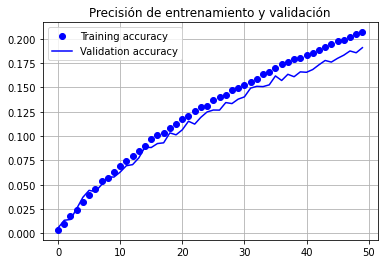

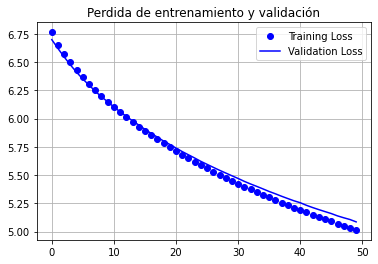

time: 422 ms (started: 2023-02-15 02:37:26 +00:00)


In [ ]:
show_history(history)

In [ ]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG)

------ Model Saved -------
time: 3.69 s (started: 2023-02-15 02:37:26 +00:00)


# Imgs 96x96

- Test Accuracy: 0.17992103099822998
- Test Loss: 5.496632099151611
- time: 33min 44s
- F1 score: 0.16775452044865566
- Precision score: 0.3381248716657463
- Recall:  0.1799210377890581
- Epoch: 50/50

## Cargar las imágenes

In [ ]:
SIZE = 96 # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE

PATH = ROOT_PATH.format(SIZE)

time: 628 µs (started: 2023-02-15 15:32:29 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 18.5 s (started: 2023-02-15 15:32:40 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()
print()

- train images: (106380, 96, 96, 1) and labels: (106380,)

- val images: (21276, 96, 96, 1) and labels: (21276,)


time: 1.14 ms (started: 2023-02-15 15:32:59 +00:00)


## Preparar el modelo

In [ ]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

94765736/94765736 [==============================] - 3s 0us/step
time: 8.9 s (started: 2023-02-15 15:33:04 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 96, 96, 3)    0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 102, 102, 3)  0           ['concatenate[0][0]']            
                                                                                              

## Entrenar el modelo

In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 54s 13ms/step - loss: 6.7862 - sparse_categorical_accuracy: 0.0026 - val_loss: 6.7412 - val_sparse_categorical_accuracy: 0.0035
Epoch 2/50
3325/3325 [==============================] - 40s 12ms/step - loss: 6.7156 - sparse_categorical_accuracy: 0.0066 - val_loss: 6.6952 - val_sparse_categorical_accuracy: 0.0102
Epoch 3/50
3325/3325 [==============================] - 39s 12ms/step - loss: 6.6684 - sparse_categorical_accuracy: 0.0133 - val_loss: 6.6523 - val_sparse_categorical_accuracy: 0.0165
Epoch 4/50
3325/3325 [==============================] - 40s 12ms/step - loss: 6.6240 - sparse_categorical_accuracy: 0.0190 - val_loss: 6.6088 - val_sparse_categorical_accuracy: 0.0252
Epoch 5/50
3325/3325 [==============================] - 41s 12ms/step - loss: 6.5808 - sparse_categorical_accuracy: 0.0251 - val_loss: 6.5687 - val_sparse_categorical_accuracy: 0.0219
Epoch 6/50
3325/3325 [==============================] - 40s 12ms/step - loss: 6.

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 3.09 s (started: 2023-02-15 16:07:18 +00:00)


In [ ]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 5s 8ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.17992103099822998
- Test Loss: 5.496632099151611
- time: 
- F1 score: 0.16775452044865566
- Precision score: 0.3381248716657463
- Recall:  0.1799210377890581
- Epoch: 
*********************************************************************************************************************************
time: 10.9 s (started: 2023-02-15 16:07:21 +00:00)


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Graficando

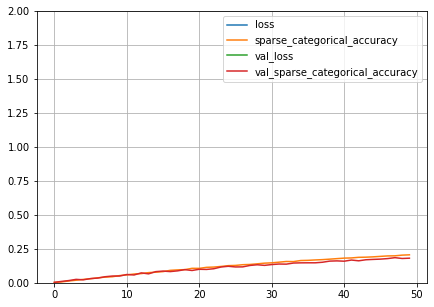

time: 260 ms (started: 2023-02-15 16:07:32 +00:00)


In [ ]:
plot_loss(history)

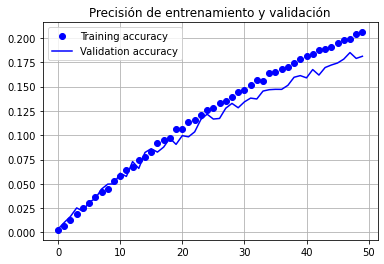

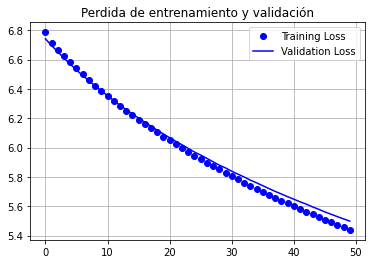

time: 395 ms (started: 2023-02-15 16:07:33 +00:00)


In [ ]:
show_history(history)

In [ ]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG)

------ Model Saved -------
time: 639 ms (started: 2023-02-15 16:07:35 +00:00)


# Imgs 112x112

- Test Accuracy: 0.355541467666626
- Test Loss: 3.7817862033843994
- time: 36min 11s
- F1 score: 0.3455364706297617
- Precision score: 0.49170370350466214
- Recall:  0.3555414551607445
- Epoch: 50/50

## Cargar imágenes

In [ ]:
SIZE = 112  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

time: 730 µs (started: 2023-02-15 16:08:48 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 20.4 s (started: 2023-02-15 16:08:49 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (106380, 112, 112, 1) and labels: (106380,)

- val images: (21276, 112, 112, 1) and labels: (21276,)

time: 1.65 ms (started: 2023-02-15 16:09:09 +00:00)


## Preparar el modelo

In [ ]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 1.76 s (started: 2023-02-15 16:09:09 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 112, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 112, 112, 3)  0           ['input_2[0][0]',                
                                                                  'input_2[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 118, 118, 3)  0           ['concatenate_1[0][0]']    

## Entrenar el modelo

In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 47s 13ms/step - loss: 6.7011 - sparse_categorical_accuracy: 0.0049 - val_loss: 6.5782 - val_sparse_categorical_accuracy: 0.0060
Epoch 2/50
3325/3325 [==============================] - 43s 13ms/step - loss: 6.4691 - sparse_categorical_accuracy: 0.0156 - val_loss: 6.3752 - val_sparse_categorical_accuracy: 0.0262
Epoch 3/50
3325/3325 [==============================] - 43s 13ms/step - loss: 6.2828 - sparse_categorical_accuracy: 0.0293 - val_loss: 6.2109 - val_sparse_categorical_accuracy: 0.0447
Epoch 4/50
3325/3325 [==============================] - 43s 13ms/step - loss: 6.1229 - sparse_categorical_accuracy: 0.0423 - val_loss: 6.0645 - val_sparse_categorical_accuracy: 0.0434
Epoch 5/50
3325/3325 [==============================] - 42s 13ms/step - loss: 5.9834 - sparse_categorical_accuracy: 0.0561 - val_loss: 5.9388 - val_sparse_categorical_accuracy: 0.0530
Epoch 6/50
3325/3325 [==============================] - 43s 13ms/step - loss: 5.

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 3.01 s (started: 2023-02-15 16:45:23 +00:00)


In [ ]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 5s 10ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.355541467666626
- Test Loss: 3.7817862033843994
- time: 
- F1 score: 0.3455364706297617
- Precision score: 0.49170370350466214
- Recall:  0.3555414551607445
- Epoch: 
*********************************************************************************************************************************
time: 12 s (started: 2023-02-15 16:45:26 +00:00)


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Graficando

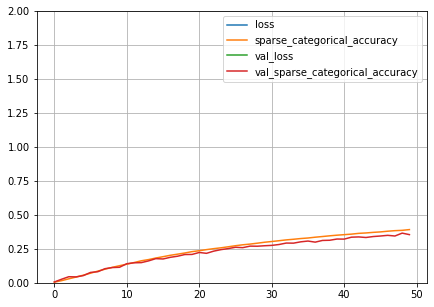

time: 198 ms (started: 2023-02-15 16:45:38 +00:00)


In [ ]:
plot_loss(history)

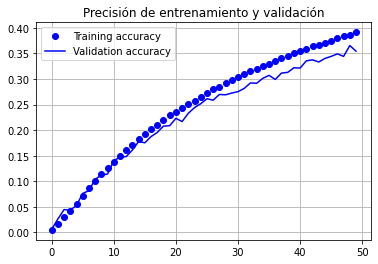

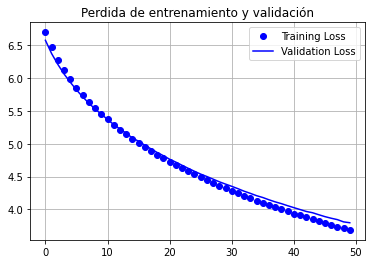

time: 379 ms (started: 2023-02-15 16:45:38 +00:00)


In [ ]:
show_history(history)

In [ ]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG)

------ Model Saved -------
time: 612 ms (started: 2023-02-15 16:45:39 +00:00)


# Imgs 127x127

- Test Accuracy: 0.1061759740114212
- Test Loss: 6.066711902618408
- time: 24min 28s
- F1 score: 0.09361094220337927
- Precision score: 0.2261184350884415
- Recall:  0.10617597292724196
- Epoch: 33/50

## Cargar las imágenes

In [ ]:
SIZE = 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

time: 606 µs (started: 2023-02-15 16:46:35 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 25.7 s (started: 2023-02-15 16:46:36 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (106380, 127, 127, 1) and labels: (106380,)

- val images: (21276, 127, 127, 1) and labels: (21276,)

time: 1.11 ms (started: 2023-02-15 16:47:02 +00:00)


## Preparar el modelo

In [ ]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 1.73 s (started: 2023-02-15 16:47:02 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 127, 127, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 127, 127, 3)  0           ['input_3[0][0]',                
                                                                  'input_3[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 133, 133, 3)  0           ['concatenate_2[0][0]']    

## Entrenar el modelo

In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 48s 14ms/step - loss: 6.7958 - sparse_categorical_accuracy: 0.0018 - val_loss: 6.7615 - val_sparse_categorical_accuracy: 0.0038
Epoch 2/50
3325/3325 [==============================] - 45s 13ms/step - loss: 6.7452 - sparse_categorical_accuracy: 0.0035 - val_loss: 6.7317 - val_sparse_categorical_accuracy: 0.0054
Epoch 3/50
3325/3325 [==============================] - 44s 13ms/step - loss: 6.7156 - sparse_categorical_accuracy: 0.0073 - val_loss: 6.7047 - val_sparse_categorical_accuracy: 0.0051
Epoch 4/50
3325/3325 [==============================] - 45s 13ms/step - loss: 6.6866 - sparse_categorical_accuracy: 0.0098 - val_loss: 6.6768 - val_sparse_categorical_accuracy: 0.0086
Epoch 5/50
3325/3325 [==============================] - 43s 13ms/step - loss: 6.6582 - sparse_categorical_accuracy: 0.0160 - val_loss: 6.6506 - val_sparse_categorical_accuracy: 0.0148
Epoch 6/50
3325/3325 [==============================] - 45s 13ms/step - loss: 6.

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 3.61 s (started: 2023-02-15 17:11:32 +00:00)


In [ ]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 5s 10ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.1061759740114212
- Test Loss: 6.066711902618408
- time: 
- F1 score: 0.09361094220337927
- Precision score: 0.2261184350884415
- Recall:  0.10617597292724196
- Epoch: 
*********************************************************************************************************************************
time: 12.4 s (started: 2023-02-15 17:11:36 +00:00)


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Graficando


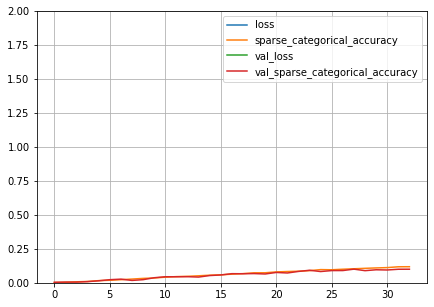

time: 202 ms (started: 2023-02-15 17:11:48 +00:00)


In [ ]:
plot_loss(history)

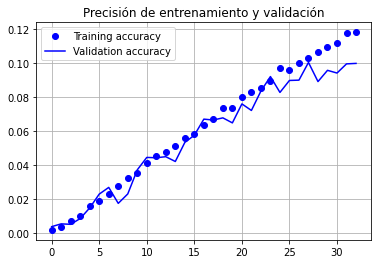

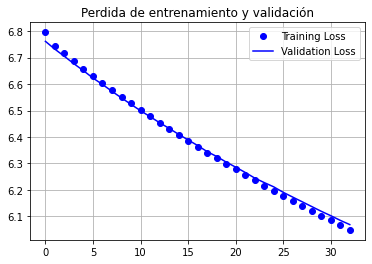

time: 390 ms (started: 2023-02-15 17:11:48 +00:00)


In [ ]:
show_history(history)

In [ ]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG)

------ Model Saved -------
time: 634 ms (started: 2023-02-15 17:11:49 +00:00)
